In [64]:
import networkx as nx
import pprint
import random
import matplotlib.pyplot as plt
import numpy as np

In [65]:
def generate_exchange_matrix(size: int, graph: nx.Graph) -> list:
    """計算機間の通信コストを表す交流行列を作成する
        通信コストはランダムに決定する
    Args:
        size (int): 行列のサイズ(計算機の数) (size x size).
        graph (nx.Graph): ネットワークトポロジのグラフ表現.

    Returns:
        list: 交流行列
    """
    adj_list = nx.to_dict_of_lists(graph)
    matrix = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            if i == j:
                matrix[i][j] = 0
            elif j in adj_list[i]:
                matrix[i][j] = random.randint(1, 100)
                matrix[j][i] = matrix[i][j]  # Set symmetric element
            else:
                matrix[i][j] = -1

    for i in range(size):
        for j in range(size):
            if j in adj_list[i]:
                graph.add_edge(i, j, weight=matrix[i][j])

    return matrix

In [66]:
def generate_random_graph(num_nodes: int) -> nx.Graph:
    """ランダムなネットワークトポロジーのグラフを作成する

    Args:
        num_nodes (int): ノードの数(計算機の数)

    Returns:
        nx.Graph: ネットワークトポロジーを表すグラフ
    """
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    for i in range(num_nodes):
        G.add_edge(i, (i + 1) % num_nodes)

    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if random.random() < 0.5:
                G.add_edge(i, j)

    return G


In [67]:
def weightintg_graph(graph: nx.Graph, exchange_matrix: list):
    """交流行列からネットワークトポロジーのグラフに重み(通信コスト)を付ける

    Args:
        graph (nx.Graph): トポロジーを表すグラフ
        exchange_matrix (list): 計算期間の通信コストを表す交流行列
    """
    num_nodes = len(exchange_matrix)
    adj_list = nx.to_dict_of_lists(graph)

    for i in range(num_nodes):
        for j in range(num_nodes):
            if j in adj_list[i]:
                graph.add_edge(i, j, weight=exchange_matrix[i][j])

In [68]:
def create_block_matrix(num_rows: int, num_cols: int) -> list:
    """ニューラルネットワークを分割したブロックの接続関係を表す行列を作成

    Args:
        num_rows (int): 分割ブロックの行数
        num_cols (int): 分割ブロックの列数

    Returns:
        list: ブロック間の接続を表す行列
        
    Example:
        num_rows = 2, num_cols = 3の場合
        -----
        1 3 5
        2 4 6
        -----
        
        となり接続関係は以下のようになる
        接続関係を持っていれば1, なければ0
        --------------------
        [[0, 1, 1, 1, 0, 0],
        [1, 0, 1, 1, 0, 0],
        [1, 1, 0, 1, 1, 1],
        [1, 1, 1, 0, 1, 1],
        [0, 0, 1, 1, 0, 1],
        [0, 0, 1, 1, 1, 0]]
        --------------------
    """
    matrix_size = num_rows * num_cols
    matrix = [[0] * matrix_size for _ in range(matrix_size)]

    # Helper function to check if a block is within the matrix bounds
    def is_valid_block(row, col):
        return 0 <= row < num_rows and 0 <= col < num_cols

    # Iterate over each block in depth-first order
    for block in range(matrix_size):
        col = block // num_rows
        row = block % num_rows

        # Connect to vertical neighbors
        if is_valid_block(row - 1, col):
            neighbor = (col * num_rows) + (row - 1)
            matrix[block][neighbor] = 1
            matrix[neighbor][block] = 1
        if is_valid_block(row + 1, col):
            neighbor = (col * num_rows) + (row + 1)
            matrix[block][neighbor] = 1
            matrix[neighbor][block] = 1

        # Connect to horizontal neighbors
        if is_valid_block(row, col - 1):
            neighbor = ((col - 1) * num_rows) + row
            matrix[block][neighbor] = 1
            matrix[neighbor][block] = 1
        if is_valid_block(row, col + 1):
            neighbor = ((col + 1) * num_rows) + row
            matrix[block][neighbor] = 1
            matrix[neighbor][block] = 1

        # Connect to diagonal neighbors
        if is_valid_block(row - 1, col - 1):
            diagonal_neighbor = ((col - 1) * num_rows) + (row - 1)
            matrix[block][diagonal_neighbor] = 1
            matrix[diagonal_neighbor][block] = 1
        if is_valid_block(row - 1, col + 1):
            diagonal_neighbor = ((col + 1) * num_rows) + (row - 1)
            matrix[block][diagonal_neighbor] = 1
            matrix[diagonal_neighbor][block] = 1
        if is_valid_block(row + 1, col - 1):
            diagonal_neighbor = ((col - 1) * num_rows) + (row + 1)
            matrix[block][diagonal_neighbor] = 1
            matrix[diagonal_neighbor][block] = 1
        if is_valid_block(row + 1, col + 1):
            diagonal_neighbor = ((col + 1) * num_rows) + (row + 1)
            matrix[block][diagonal_neighbor] = 1
            matrix[diagonal_neighbor][block] = 1

    return matrix


In [69]:
def generate_block_list(num_blocks: int) -> list:
    """分割したブロックの番号リスト

    Args:
        num_nodes (int): 分割ブロックの数

    Returns:
        list: ブロックの番号リスト
        
    Example:
        num_blocks = 6の場合
        ------------------
        [0, 1, 2, 3, 4, 5]
        ------------------
    """    
    block_list = []
    for i in range(num_blocks):
        block_list.append(i)
    return block_list

In [70]:
def generate_assignment_matrix(num_pcs: int, num_blocks: int) -> list:
    values = []
    base_counts = num_blocks // num_pcs  # 基準となる個数
    remaining = num_blocks % num_pcs  # 残りの個数

    # 基準となる個数での乱数生成
    for pc in range(num_pcs):
        values.extend([pc] * base_counts)

    # 残りの個数を等しい比率で乱数生成
    remaining_values = random.choices(range(num_pcs), k=remaining)
    values.extend(remaining_values)

    # 乱数をシャッフル
    random.shuffle(values)

    return values

In [71]:
def get_pc_by_block_label(block_label: int, assigned_matrix: list) -> int:
    """ブロックのラベルから担当する計算機の番号を返す

    Args:
        block_label (int): ブロックのラベル
        task_matrix (list): 計算機が担当するブロックを表す行列

    Returns:
        int: 計算機の番号
    """
    pc_num = len(assigned_matrix)
    for i in range(pc_num):
        if i == block_label:
            return assigned_matrix[i]
    

In [72]:
def get_tasks_by_pc(pc: int, assigned_matrix: list) -> int:
    """計算機の番号から担当するブロックのラベルを返す

    Args:
        block_label (int): ブロックのラベル
        assigned_matrix (list): 計算機が担当するブロックを表す行列

    Returns:
        int: ブロックのラベル
    """
    tasks = []
    for i in range(len(assigned_matrix)):
        if pc == assigned_matrix[i]:
            tasks.append(i)
    return tasks

In [73]:
def get_linked_blocks(block_label: int, block_linked_matrix: list) -> list:
    """ブロックのラベルから接続しているブロックのラベルのリストを返す

    Args:
        block_labe (int): ブロックのラベル
        matrix (list): 接続関係を持つ行列

    Returns:
        list: 接続しているブロックのラベルのリスト
    """
    linked_blocks = []
    for i in range(len(block_linked_matrix)):
        if block_linked_matrix[block_label][i] == 1:
            linked_blocks.append(i)
    return linked_blocks

In [74]:
def get_communication_cost(starting_point_pc: int, graph: nx.graph, linked_blocks) -> int:
    """始点の計算機から各計算機への通信コストを取得する

    Args:
        starting_point_pc (int): 始点の計算機の番号
        exchange_matrix (list): 通信コストを表す行列

    Returns:
        int: 始点の計算機から各計算機への通信コスト
        -> ダイクストラで計算
    """
    cost = 0
    for target in linked_blocks:
        cost += nx.dijkstra_path_length(graph, starting_point_pc, target)
    return cost

交流行列
[[ 0. 37. 90.  7.]
 [37.  0. 28. -1.]
 [90. 28.  0. 43.]
 [ 7. -1. 43.  0.]]

ニューラルネットワークの分割ブロックの接続関係を表す行列
[[0, 1, 1, 1, 0, 0],
 [1, 0, 1, 1, 0, 0],
 [1, 1, 0, 1, 1, 1],
 [1, 1, 1, 0, 1, 1],
 [0, 0, 1, 1, 0, 1],
 [0, 0, 1, 1, 1, 0]]

分割ブロックの番号リスト
[0, 1, 2, 3, 4, 5]

PCが担当するブロックの割り当てを表す行列
G = [3, 2, 1, 0, 2, 3]

ブロック0を担当するPCの番号: 3
PC3が担当するブロックの番号リスト: [0, 5]
ブロック0に接続しているブロックの番号リスト: [1, 2, 3]


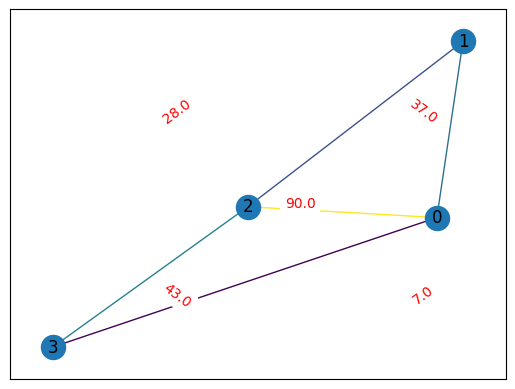

In [75]:
# ネットワークトポロジーを作成
G = generate_random_graph(4)

# 交流行列を作成
exchange_matrix = generate_exchange_matrix(size=4, graph=G)

# グラフのエッジに通信コスト(交流行列より)を付与
weightintg_graph(G, exchange_matrix)

# グラフの描画
pos = nx.circular_layout(G)
weights = nx.get_edge_attributes(G, 'weight').values()
nx.draw_networkx(G, edge_color = weights)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')


num_pcs = 4
num_blocks = 6
print("交流行列")
print(exchange_matrix)

block_linked_matrix = create_block_matrix(num_rows=2, num_cols=3)
print("\nニューラルネットワークの分割ブロックの接続関係を表す行列")
pprint.pprint(block_linked_matrix)

block_list = generate_block_list(6)
print("\n分割ブロックの番号リスト")
print(block_list)

# Distribute tasks to computers
assigned_matrix = generate_assignment_matrix(num_pcs, num_blocks)
print("\nPCが担当するブロックの割り当てを表す行列")
print(f'G = {assigned_matrix}')
    

pc = get_pc_by_block_label(block_label=0, assigned_matrix=assigned_matrix)
print(f'\nブロック0を担当するPCの番号: {pc}')
tasks = get_tasks_by_pc(pc=pc, assigned_matrix=assigned_matrix)
print(f'PC{pc}が担当するブロックの番号リスト: {tasks}')
linked_blocks = get_linked_blocks(block_label=0, block_linked_matrix=block_linked_matrix)
print(f'ブロック{0}に接続しているブロックの番号リスト: {linked_blocks}')

In [76]:
print(f'G = {assigned_matrix}')
for block_label in range(num_blocks):
    pc = get_pc_by_block_label(block_label, assigned_matrix=assigned_matrix)
    print(f'\nブロック{block_label}を担当するPCの番号: {pc}')
    linked_blocks = get_linked_blocks(block_label, block_linked_matrix=block_linked_matrix)
    print(f'ブロック{block_label}に接続しているブロックの番号リスト: {linked_blocks}')

G = [3, 2, 1, 0, 2, 3]

ブロック0を担当するPCの番号: 3
ブロック0に接続しているブロックの番号リスト: [1, 2, 3]

ブロック1を担当するPCの番号: 2
ブロック1に接続しているブロックの番号リスト: [0, 2, 3]

ブロック2を担当するPCの番号: 1
ブロック2に接続しているブロックの番号リスト: [0, 1, 3, 4, 5]

ブロック3を担当するPCの番号: 0
ブロック3に接続しているブロックの番号リスト: [0, 1, 2, 4, 5]

ブロック4を担当するPCの番号: 2
ブロック4に接続しているブロックの番号リスト: [2, 3, 5]

ブロック5を担当するPCの番号: 3
ブロック5に接続しているブロックの番号リスト: [2, 3, 4]


In [77]:
import numpy as np

def ensure_one_way_connections(adjacency_matrix):
    num_nodes = adjacency_matrix.shape[0]
    for i in range(num_nodes):
        for j in range(num_nodes):
            if adjacency_matrix[i, j] == 1 and adjacency_matrix[j, i] == 0:
                adjacency_matrix[i, j] = 0
    return adjacency_matrix

block_linked_matrix = np.array(block_linked_matrix)
print(block_linked_matrix)
result = ensure_one_way_connections(block_linked_matrix)
print(result)


[[0 1 1 1 0 0]
 [1 0 1 1 0 0]
 [1 1 0 1 1 1]
 [1 1 1 0 1 1]
 [0 0 1 1 0 1]
 [0 0 1 1 1 0]]
[[0 1 1 1 0 0]
 [1 0 1 1 0 0]
 [1 1 0 1 1 1]
 [1 1 1 0 1 1]
 [0 0 1 1 0 1]
 [0 0 1 1 1 0]]
